In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import celltypist
import seaborn as sns
from rich import print
#from scib_metrics.benchmark import Benchmarker

/home/users/isakova/.local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
  """ Implements modularity. This quality function is well-defined only for positive edge weights.
/home/users/isakova/.local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
  """ Implements Reichardt and Bornholdt's Potts model with a configuration null model.
/home/users/isakova/.local/lib/python3.12/site-packages/leidenalg/Optimiser.py:7: SyntaxWarning: invalid escape sequence '\g'
  """ Class for doing community detection using the Leiden algorithm.
/home/users/isakova/.local/lib/python3.12/site-packages/leidenalg/Optimiser.py:305: SyntaxWarning: invalid escape sequence '\s'
  """ Optimise the given partitions simultaneously.


In [2]:
adata = sc.read('TSB_annotated_log1p_scvi_full_annotated.h5ad')

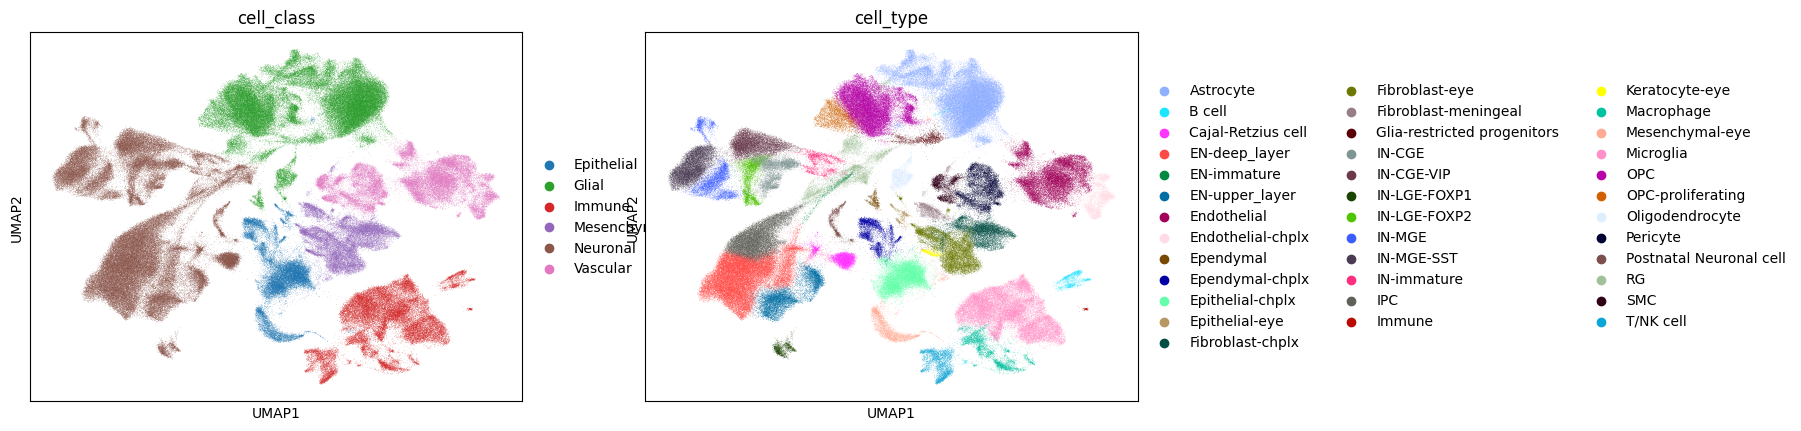

In [8]:
sc.pl.umap(adata, color=['cell_class', 'cell_type'])

In [5]:
cell_types = adata.obs["cell_type"].unique().tolist()
print(cell_types)

[
    'OPC-proliferating',
    'IN-MGE',
    'OPC',
    'Glia-restricted progenitors',
    'Astrocyte',
    'RG',
    'Microglia',
    'IN-LGE-FOXP1',
    'IN-LGE-FOXP2',
    'Macrophage',
    'IN-immature',
    'IN-CGE-VIP',
    'IN-MGE-SST',
    'B cell',
    'Endothelial-chplx',
    'IN-CGE',
    'Pericyte',
    'Cajal-Retzius cell',
    'Epithelial-eye',
    'Epithelial-chplx',
    'Oligodendrocyte',
    'Endothelial',
    'EN-deep_layer',
    'T/NK cell',
    'Mesenchymal-eye',
    'Fibroblast-meningeal',
    'Fibroblast-chplx',
    'EN-upper_layer',
    'Ependymal-chplx',
    'IPC',
    'Postnatal Neuronal cell',
    'SMC',
    'Fibroblast-eye',
    'EN-immature',
    'Immune',
    'Ependymal',
    'Keratocyte-eye'
]

### Subset Glial Cell Class

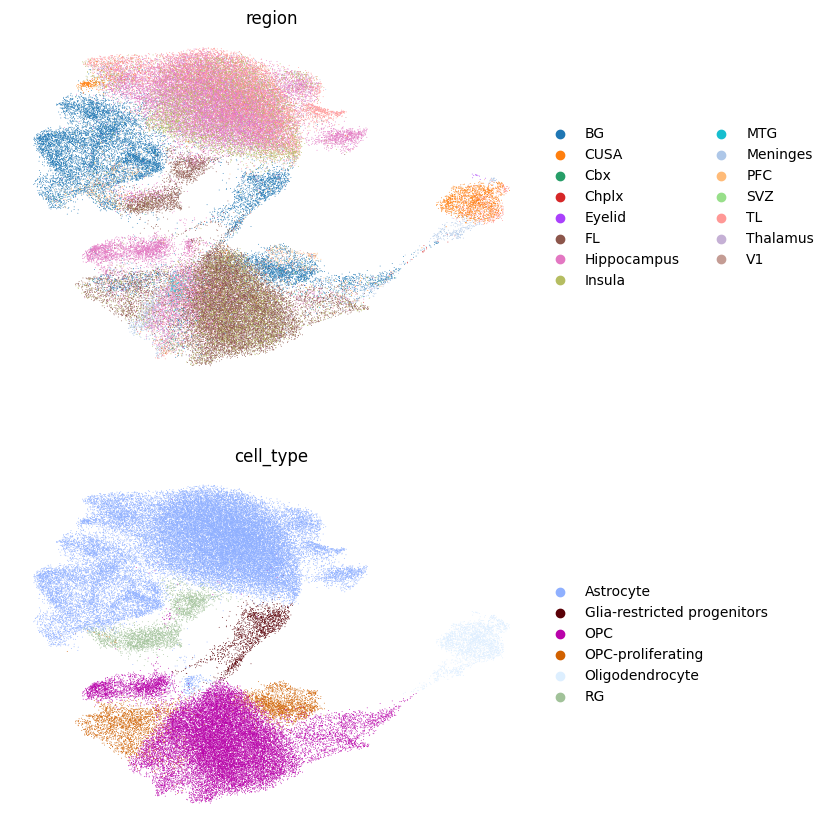

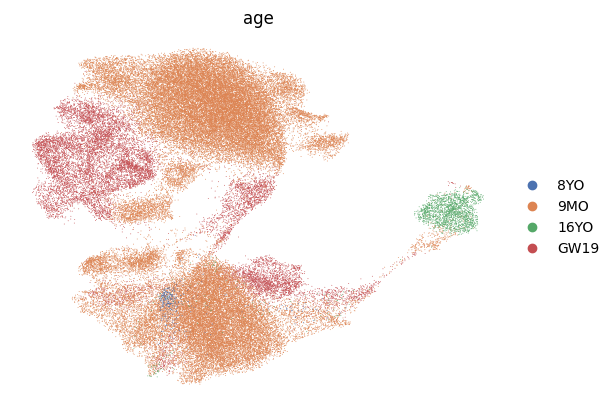

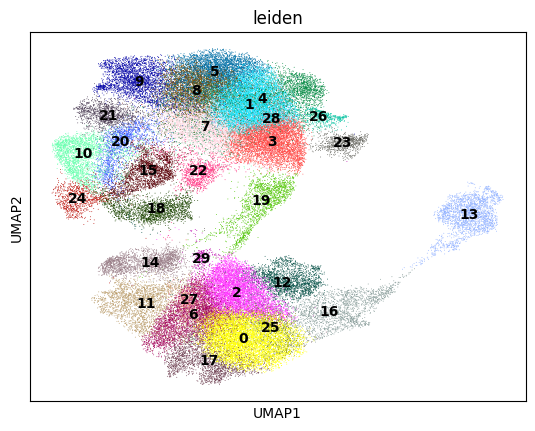

In [21]:
original_cell_type_colors = adata.uns["cell_type_colors"]
original_cell_type_order = adata.obs["cell_type"].cat.categories

glial_adata = adata[adata.obs["cell_class"] == "Glial"].copy()

glial_adata.obs["cell_type"] = glial_adata.obs["cell_type"].astype("category")

# Restore the same category order (this maps colors correctly)
glial_adata.obs["cell_type"] = glial_adata.obs["cell_type"].cat.set_categories(original_cell_type_order)

# Restore the colors (must match order of categories)
glial_adata.uns["cell_type_colors"] = original_cell_type_colors

# Define all neuronal cell type labels you want to keep
glial_labels = [
    'OPC-proliferating',
    'OPC',
    'Glia-restricted progenitors',
    'RG',
    'Astrocyte',
    'Oligodendrocyte',
]
# Subset to only include these neuronal cell types
glial_adata = glial_adata[glial_adata.obs['cell_type'].isin(glial_labels)].copy()

#glial_adata = glial_adata[glial_adata.obs['n_genes_by_counts'] > 700].copy()
# Ensure cell_type is categorical (important!)

# Shrink categories to only those present
glial_adata.obs["cell_type"] = glial_adata.obs["cell_type"].cat.remove_unused_categories()

# Re-derive the colors just for present categories
remaining_categories = glial_adata.obs["cell_type"].cat.categories
original_color_map = dict(zip(original_cell_type_order, original_cell_type_colors))

# Apply only the colors for present categories
glial_adata.uns["cell_type_colors"] = [original_color_map[cat] for cat in remaining_categories]

sc.pp.neighbors(glial_adata, use_rep="X_scVI")
sc.tl.umap(glial_adata)
sc.tl.leiden(glial_adata, resolution=2)

sc.pl.umap(
    glial_adata,
    color=["region", "cell_type"],
    frameon=False,
    ncols=1,
)
sc.pl.umap(
    glial_adata,
    color=["age"],
    frameon=False,
    ncols=1,
)

sc.pl.umap(glial_adata, color="leiden", legend_loc="on data")

In [9]:
## Define the gene list
#marker_genes = ['OLIG1', 'OLIG2','PDGFRA', 'SOX10', 'NFIA', 'NFIB',"SOX9","HES5",'AQP4']
# Check which genes are present in the dataset
#present_genes = [gene for gene in marker_genes if gene in glial_adata.var_names]

#print(f"Plotting UMAP for {len(present_genes)} marker genes.")

# Plot UMAPs for each gene
#sc.pl.umap(
#    glial_adata, 
#    color=present_genes, 
#    ncols=3, 
#    cmap='viridis', 
#    size=20, 
#    vmin=1, 
#    vmax='p99'
#)


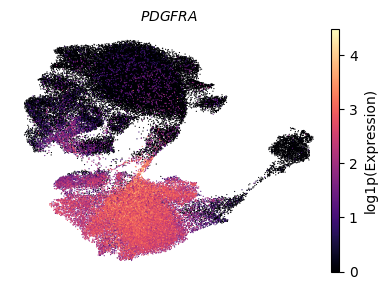

In [22]:
from matplotlib.colors import LinearSegmentedColormap

# Define a custom gray-to-red colormap
gray_red_cmap = LinearSegmentedColormap.from_list("gray_red", ["lightgray", "#a9373b"])

# Set figure size (width, height in inches); make it small and square
fig = sc.pl.umap(glial_adata, color=['PDGFRA'], wspace=0.5,
    size=3, show=False, frameon=False,
    layer=None,cmap='magma')

fig = plt.gcf()
fig.set_size_inches(4, 3)  # e.g., width=4, height=4 for square
# Make UMAP panel titles (gene names) italic
for ax in fig.axes:
    title = ax.get_title()
    if title:  # Only modify if title exists
        ax.set_title(r"$\mathit{{{}}}$".format(title), fontsize=10)

for ax in fig.axes:
    if hasattr(ax, 'get_ylabel') and 'color' in ax.get_label().lower():
        ax.set_ylabel("log1p(Expression)", fontsize=10)
    # OR label any axis with a visible colorbar
    if ax.get_position().x0 > 0.85:  # Usually the colorbar is to the far right
        ax.set_ylabel("log1p(Expression)", fontsize=10)

#plt.suptitle("sfRNA Load (sfRNA1-4)", fontsize=12)
plt.tight_layout()
#plt.savefig("umap_ex_marker.pdf", format='pdf', bbox_inches='tight')
plt.savefig("umap_glia_marker_PDGFRA.png", dpi=300, bbox_inches='tight')
#plt.savefig("umap_ex_marker_v2.pdf", bbox_inches='tight')
plt.show()

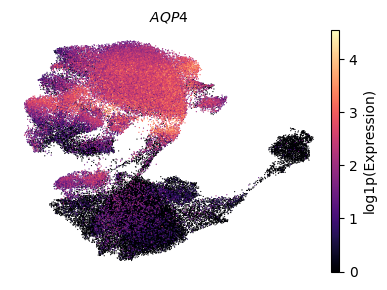

In [23]:
from matplotlib.colors import LinearSegmentedColormap

# Define a custom gray-to-red colormap
gray_red_cmap = LinearSegmentedColormap.from_list("gray_red", ["lightgray", "#a9373b"])

# Set figure size (width, height in inches); make it small and square
fig = sc.pl.umap(glial_adata, color=['AQP4'], wspace=0.5,
    size=3, show=False, frameon=False,
    layer=None,cmap='magma')

fig = plt.gcf()
fig.set_size_inches(4, 3)  # e.g., width=4, height=4 for square
# Make UMAP panel titles (gene names) italic
for ax in fig.axes:
    title = ax.get_title()
    if title:  # Only modify if title exists
        ax.set_title(r"$\mathit{{{}}}$".format(title), fontsize=10)

for ax in fig.axes:
    if hasattr(ax, 'get_ylabel') and 'color' in ax.get_label().lower():
        ax.set_ylabel("log1p(Expression)", fontsize=10)
    # OR label any axis with a visible colorbar
    if ax.get_position().x0 > 0.85:  # Usually the colorbar is to the far right
        ax.set_ylabel("log1p(Expression)", fontsize=10)

#plt.suptitle("sfRNA Load (sfRNA1-4)", fontsize=12)
plt.tight_layout()
#plt.savefig("umap_ex_marker.pdf", format='pdf', bbox_inches='tight')
plt.savefig("umap_glia_marker_AQP4.png", dpi=300, bbox_inches='tight')
#plt.savefig("umap_ex_marker_v2.pdf", bbox_inches='tight')
plt.show()

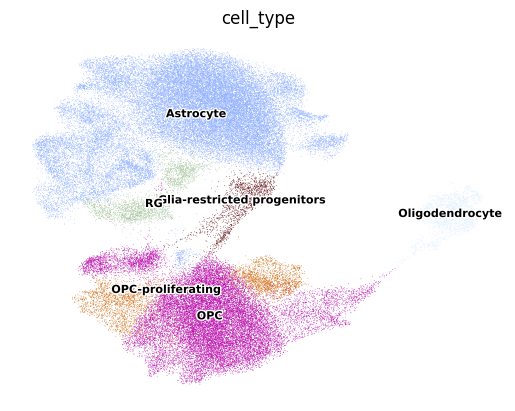

In [24]:
# Plot UMAP
sc.pl.umap(
    glial_adata,
    color=["cell_type"],
    legend_loc="on data",
    size=1,
    ncols=1,
    frameon=False,
    legend_fontsize=8,
    legend_fontoutline=2,
    save="Glial_umap.pdf"  # Optional
)

/tmp/ipykernel_23902/2215138005.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  region_props = region_counts.pivot_table(index='cell_type', columns='region_renamed', values='count', fill_value=0)


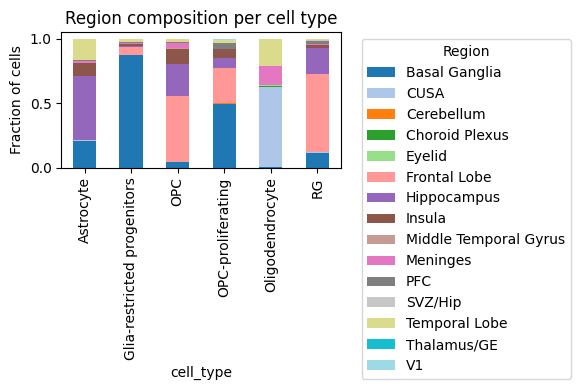

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Copy relevant metadata
df = glial_adata.obs[['cell_type', 'region']].copy()

# Step 2: Apply region renaming
region_map = {
    'BG': 'Basal Ganglia',
    'Cbx': 'Cerebellum',
    'Chplx': 'Choroid Plexus',
    'Eyelid': 'Eyelid',
    'FL': 'Frontal Lobe',
    'PFC': 'PFC',
    'SVZ': 'SVZ/Hip',
    'TL': 'Temporal Lobe',
    'Thalamus': 'Thalamus/GE',
    'V1': 'V1',
    'Hippocampus': 'Hippocampus',
    'Insula': 'Insula',
    'Meninges': 'Meninges',
    'CUSA': 'CUSA',
    'MTG': 'Middle Temporal Gyrus'
}
df['region_renamed'] = df['region'].map(region_map)

# Step 3: Count and normalize
region_counts = df.value_counts(['cell_type', 'region_renamed']).reset_index(name='count')
region_props = region_counts.pivot_table(index='cell_type', columns='region_renamed', values='count', fill_value=0)
region_props = region_props.div(region_props.sum(axis=1), axis=0)

# Step 4: Plot
region_props.plot(kind='bar', stacked=True, colormap='tab20', figsize=(6, 4))
plt.ylabel("Fraction of cells")
plt.title("Region composition per cell type")
plt.xticks(rotation=90)
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("glial_cell_fraction_by_region.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [27]:
glial_adata.write("TSB_Glial.h5ad")

In [4]:
import scanpy as sc
glial_adata = sc.read("TSB_Glial.h5ad")

## Calculate PAGA and define lineages

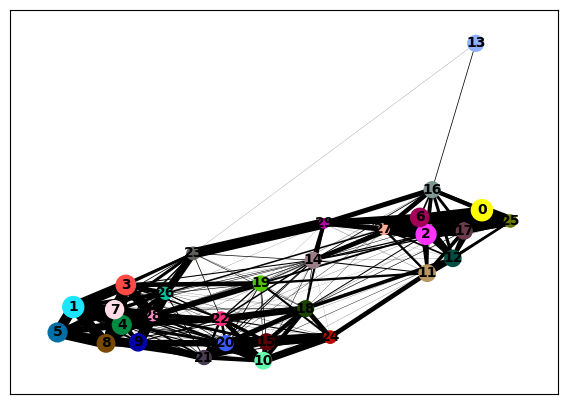

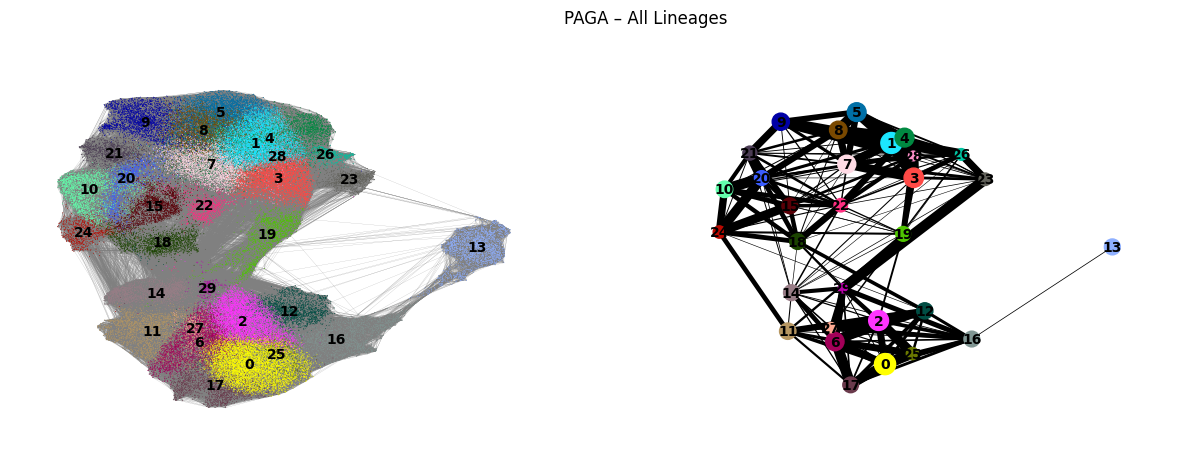

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

In [28]:
sc.tl.paga(glial_adata, groups="leiden")
sc.pl.paga(glial_adata, color=["leiden"])
# Visualize on UMAP
sc.pl.paga_compare(
    glial_adata,
    basis='umap',
    edges=True,
    title='PAGA – All Lineages',
    threshold=0.05
)

#import numpy as np
#glial_adata.uns["iroot"] = np.flatnonzero(glial_adata.obs["leiden"] == "16")[0]

#sc.tl.diffmap(neuronal_adata, n_comps=20)
#sc.tl.dpt(neuronal_adata,n_dcs=20)
#sc.pl.umap(neuronal_adata, color=["leiden", "dpt_pseudotime"], legend_loc="on data")

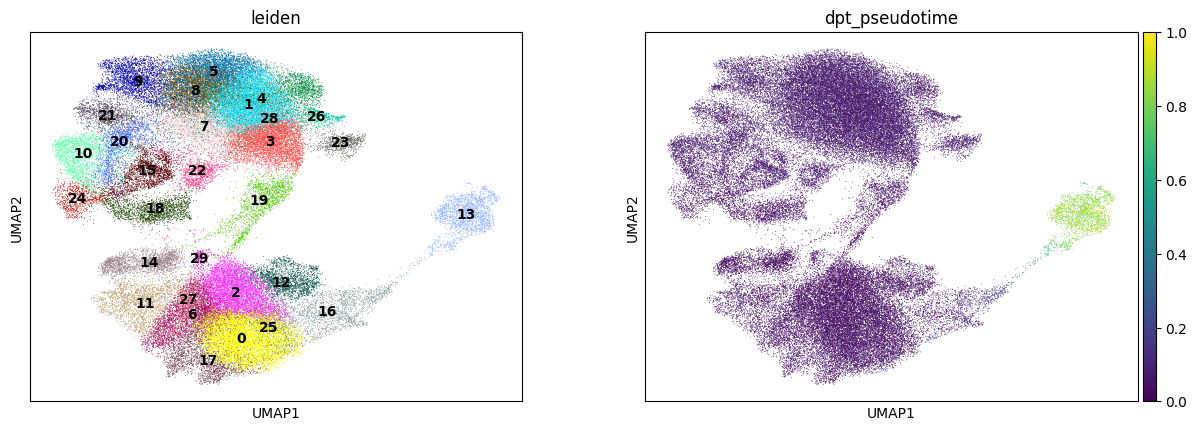

In [30]:
import numpy as np
glial_adata.uns["iroot"] = np.flatnonzero(glial_adata.obs["leiden"] == "19")[0]

sc.tl.diffmap(glial_adata, n_comps=20)
sc.tl.dpt(glial_adata,n_dcs=20)
sc.pl.umap(glial_adata, color=["leiden", "dpt_pseudotime"], legend_loc="on data")

### Assign lineages and plot pseudotime by lineage

In [5]:
paths = [
    ("Astrocyte", [18, 3,28,1,4,26,23,7,22,24,15,10,20,21,8,5,9]),
    ("OPC", [19,14,29,11,27,2,6,0,17,25,12,16]),
    ("Oligodendrocyte", [13]),
]


/home/users/isakova/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


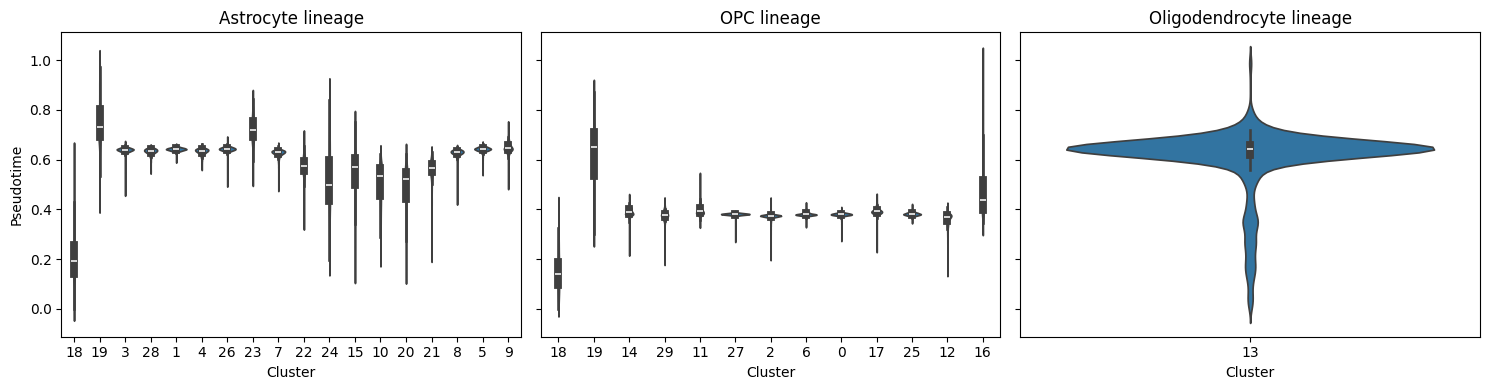

In [6]:
lineage_pseudotime = {}

for descr, path in paths:
    start_node = str(path[0])  # clusters as strings if using 'leiden'
    path_clusters = list(map(str, path))
    cells = glial_adata.obs['leiden'].isin(path_clusters)
    adata_path = glial_adata[cells].copy()
    
    # Required preprocessing
    sc.pp.neighbors(adata_path, use_rep='X_scVI')  # or your preferred embedding
    sc.tl.diffmap(adata_path)
    # pick a root cell index from the start_node cluster
    # Set the correct root cell
    root_cell_name = adata_path.obs[adata_path.obs['leiden'] == start_node].index[0]
    root_cell_idx = adata_path.obs_names.get_loc(root_cell_name)
    adata_path.uns['iroot'] = root_cell_idx
    sc.tl.dpt(adata_path)

    adata_path.obs['lineage'] = descr
    lineage_pseudotime[descr] = adata_path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axs = plt.subplots(ncols=len(lineage_pseudotime), figsize=(5 * len(lineage_pseudotime), 4), sharey=True)

for ax, (descr, adata) in zip(axs, lineage_pseudotime.items()):
    df = pd.DataFrame({
        'pseudotime': adata.obs['dpt_pseudotime'],
        'cluster': adata.obs['leiden'],
    })

    # Sort cluster order by path, if needed
    cluster_order = list(map(str, paths[[p[0] for p in paths].index(descr)][1]))

    sns.violinplot(data=df, x='cluster', y='pseudotime', order=cluster_order, ax=ax)
    ax.set_title(f"{descr} lineage")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Pseudotime")

plt.tight_layout()
plt.show()


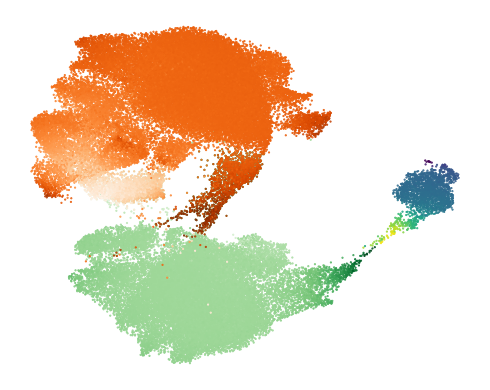

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Reset combined object from the full neuronal_adata
combined = glial_adata.copy()

# Create empty pseudotime columns
for descr in lineage_pseudotime:
    combined.obs[f'pseudotime_{descr}'] = np.nan
    combined.obs.loc[lineage_pseudotime[descr].obs_names, f'pseudotime_{descr}'] = \
        lineage_pseudotime[descr].obs['dpt_pseudotime']

# UMAP coordinates
umap_coords = combined.obsm['X_umap']

# Define colormaps for each lineage
color_map_dict = {  
    "Astrocyte": "Oranges",
    "OPC": "Greens",
    "Oligodendrocyte": "viridis_r",
}

fig, ax = plt.subplots(figsize=(5, 4))

scatters = []
for descr in reversed(paths):
    lineage_name = descr[0]
    colname = f"pseudotime_{lineage_name}"
    if colname not in combined.obs:
        continue
    mask = ~combined.obs[colname].isna()
    pseudotime_values = combined.obs[colname][mask]
    scatter = ax.scatter(
        umap_coords[mask, 0],
        umap_coords[mask, 1],
        c=pseudotime_values,
        cmap=color_map_dict.get(lineage_name, 'viridis'),
        s=0.3,
        label=lineage_name
    )
    scatters.append((scatter, lineage_name))

# Final formatting
#ax.set_title("Lineage-specific pseudotime on shared UMAP")
ax.axis('off')
#ax.legend(loc='upper right', markerscale=2)

# Optional: Add a colorbar for each (can get crowded though)
# Optional: Add a colorbar for each (can get crowded though)
#for i, (scat, name) in enumerate(scatters):
#    cbar = plt.colorbar(scat, ax=ax, fraction=0.03) #, pad=0.01 + 0.05 * i)
#    cbar.set_label(f'{name} pseudotime', rotation=270, labelpad=15)

plt.tight_layout()
plt.savefig("glial_lineage_pseudotime_umap.png", dpi=300, bbox_inches='tight')
#plt.savefig("glial_lineage_pseudotime_umap2.pdf")
plt.show()


In [8]:
print(sc.__version__)

1.11.0


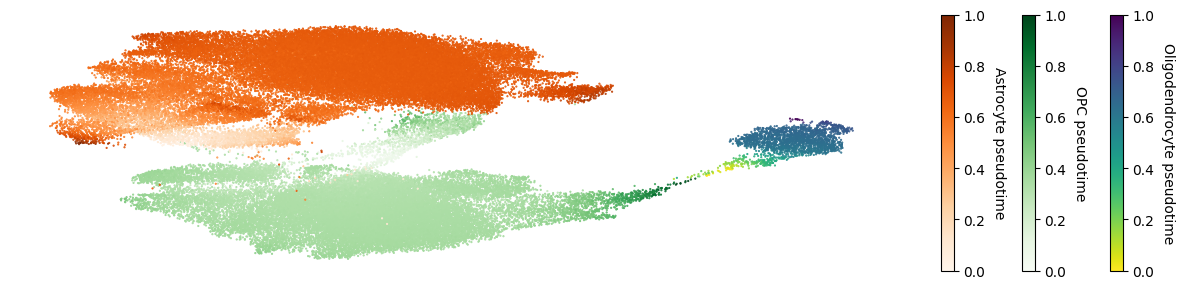

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Reset combined object from the full neuronal_adata
combined = glial_adata.copy()

# Create empty pseudotime columns
for descr in lineage_pseudotime:
    combined.obs[f'pseudotime_{descr}'] = np.nan
    combined.obs.loc[lineage_pseudotime[descr].obs_names, f'pseudotime_{descr}'] = \
        lineage_pseudotime[descr].obs['dpt_pseudotime']

# UMAP coordinates
umap_coords = combined.obsm['X_umap']


fig, ax = plt.subplots(figsize=(12, 3))

scatters = []
for descr in reversed(paths):
    lineage_name = descr[0]
    colname = f"pseudotime_{lineage_name}"
    if colname not in combined.obs:
        continue
    mask = ~combined.obs[colname].isna()
    pseudotime_values = combined.obs[colname][mask]
    scatter = ax.scatter(
        umap_coords[mask, 0],
        umap_coords[mask, 1],
        c=pseudotime_values,
        cmap=color_map_dict.get(lineage_name, 'viridis'),
        s=0.3,
        label=lineage_name
    )
    scatters.append((scatter, lineage_name))

# Final formatting
#ax.set_title("Lineage-specific pseudotime on shared UMAP")
ax.axis('off')
#ax.legend(loc='upper right', markerscale=2)

# Optional: Add a colorbar for each (can get crowded though)
# Optional: Add a colorbar for each (can get crowded though)
for i, (scat, name) in enumerate(scatters):
    cbar = plt.colorbar(scat, ax=ax, fraction=0.03) #, pad=0.01 + 0.05 * i)
    cbar.set_label(f'{name} pseudotime', rotation=270, labelpad=15)

plt.tight_layout()
#plt.savefig("glial_lineage_pseudotime_umap.png", dpi=300, bbox_inches='tight')
plt.savefig("glial_lineage_pseudotime_umap2.pdf")
plt.show()


### Annotate adata with lineage

In [49]:
# Step 1: Convert paths list to a cluster → lineage dictionary
cluster_to_lineage = {}

for lineage_name, cluster_list in paths:
    for cluster in cluster_list:
        cluster_to_lineage[str(cluster)] = lineage_name  # Ensure cluster labels are strings

# Step 2: Create a new 'lineage' column in obs
glial_adata.obs['lineage'] = glial_adata.obs['leiden'].map(cluster_to_lineage)

# Step 3: Inspect unique lineage assignments
print(glial_adata.obs['lineage'].value_counts(dropna=False))


lineage
Astrocyte          43272
OPC                30314
Oligodendrocyte     2209
Name: count, dtype: int64

#### Add individual pseudotime to adata

In [50]:
import numpy as np

# Initialize the column with NaN
glial_adata.obs['individual_pseudotime'] = np.nan

# Fill in pseudotime values for each lineage subset
for descr, adata_sub in lineage_pseudotime.items():
    glial_adata.obs.loc[adata_sub.obs_names, 'individual_pseudotime'] = adata_sub.obs['dpt_pseudotime']


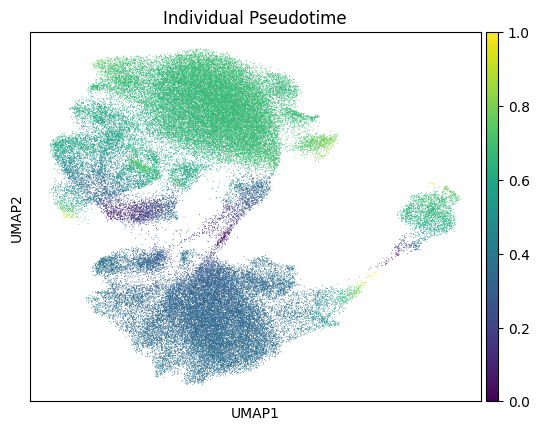

In [51]:
import scanpy as sc
sc.pl.umap(glial_adata, color='individual_pseudotime', cmap='viridis', title="Individual Pseudotime")


### Now extract DEGs and plot them as heatmap

### Identify genes dynamicly changing within lineages

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc

# Define noncoding biotypes
noncoding_types = ['miRNA', 'lncRNA', 'snoRNA', 'snRNA', 'scaRNA']

# Store results
all_deg_results = []

for lineage_name, _ in paths:
    adata = lineage_pseudotime[lineage_name].copy()

    # 1. Subset to non-coding genes
    var_df = adata.var.copy()
    var_df = var_df.reset_index().rename(columns={'index': 'gene'})
    noncoding_genes = var_df[var_df['biotype'].isin(noncoding_types)]['gene'].values
    adata = adata[:, adata.var_names.isin(noncoding_genes)].copy()

    # 2. Bin pseudotime
    pseudotime = adata.obs['dpt_pseudotime']
    quantiles = pseudotime.quantile([0.1, 0.5, 0.6, 0.9])
    bins = pd.cut(
        pseudotime,
        bins=[-np.inf, quantiles[0.1], quantiles[0.6], np.inf],
        labels=['early', 'mid', 'late']
    )
    adata.obs['pt_bin'] = bins

    # 3. Subset to early, mid, late
    keep = adata.obs['pt_bin'].isin(['early', 'mid', 'late'])
    adata = adata[keep].copy()

    # 4. Run DEG analysis
    sc.tl.rank_genes_groups(
        adata,
        groupby='pt_bin',
        method='wilcoxon',
        pts=True,
        use_raw=False
    )

    # 5. Format result into DataFrame
    result = sc.get.rank_genes_groups_df(adata, group=None)
    result['lineage'] = lineage_name
    all_deg_results.append(result)

# 6. Concatenate all DEG results
deg_df = pd.concat(all_deg_results, ignore_index=True)

# 7. Filter for significance (optional)
sig_deg_df = deg_df.query('pvals_adj < 0.05 and abs(logfoldchanges) > 1')

# Optional: save or preview
print(sig_deg_df.head())
# sig_deg_df.to_csv("noncoding_deg_by_lineage.csv", index=False)


In [87]:
sig_deg_df.to_csv("glial_noncoding_deg_by_lineage.csv", index=False)


In [89]:
biotypes = (
    glial_adata.var[['biotype']]
    .reset_index()
    .rename(columns={'index': 'names'})  # assuming gene names are in index
)

sig_df = sig_deg_df.merge(biotypes, on='names', how='left')

top_genes = (
    sig_df
    .groupby(['biotype', 'names'])['logfoldchanges']
    .max()
    .reset_index()
    .sort_values(['biotype', 'logfoldchanges'], ascending=[True, False])
    .groupby('biotype')
    .head(20)['names']
    .unique()
    .tolist()
)


/tmp/ipykernel_25186/3078578715.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['biotype', 'names'])['logfoldchanges']
/tmp/ipykernel_25186/3078578715.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('biotype')


/tmp/ipykernel_25186/3586333821.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


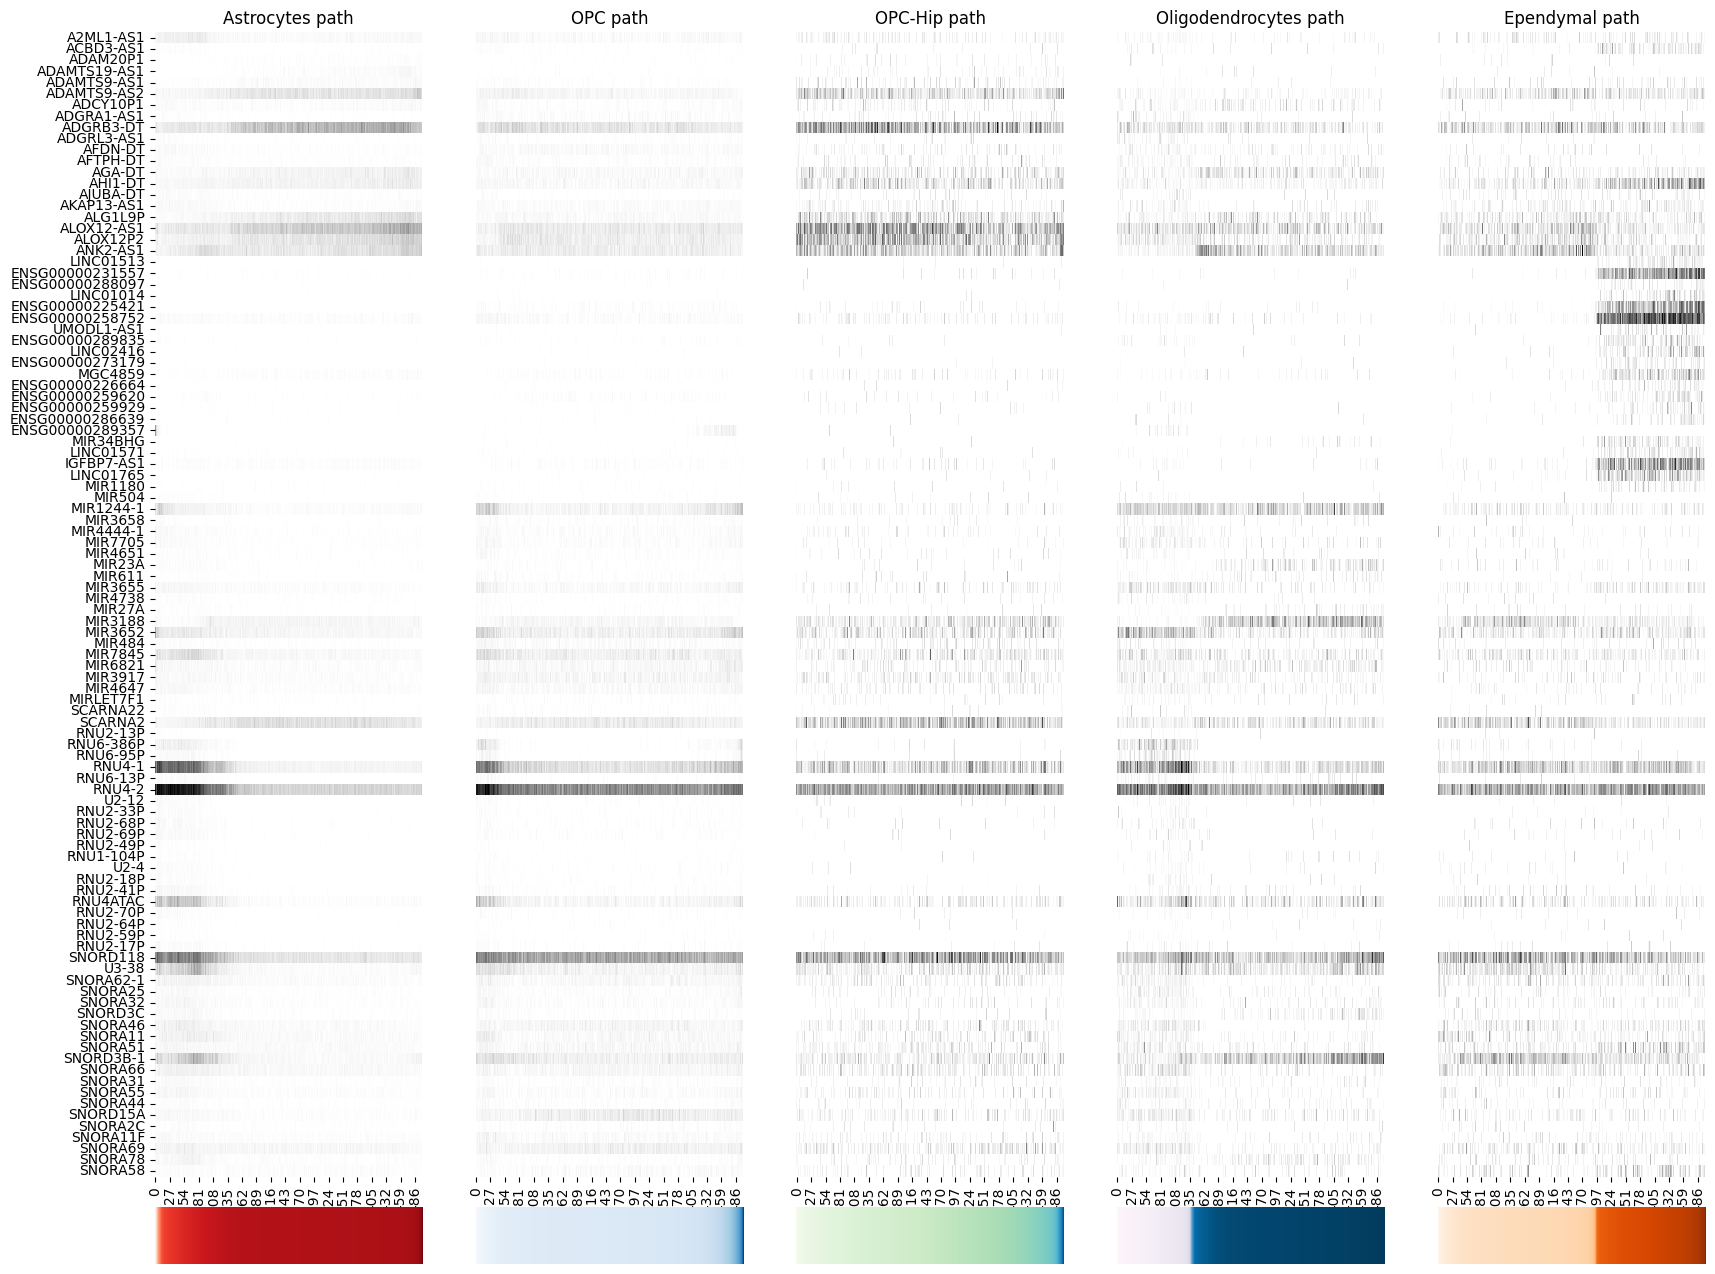

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Parameters
n_bins = 500


# Set up figure and layout
fig = plt.figure(figsize=(4 * len(paths), 16))
gs = gridspec.GridSpec(2, len(paths), height_ratios=[20, 1], hspace=0.05)

for ipath, (descr, path) in enumerate(paths):
    adata = lineage_pseudotime[descr]
    pseudotime = adata.obs['dpt_pseudotime'].copy()

    # 1. Z-score expression across all cells for selected genes
    raw_expr = adata[:, top_genes].to_df()
    df_expr = (raw_expr - raw_expr.min(axis=0)) / (raw_expr.max(axis=0) - raw_expr.min(axis=0))


    # 2. Assign pseudotime bins
    bins = pd.qcut(pseudotime, q=n_bins, labels=False)
    df_expr['pseudotime_bin'] = bins

    # 3. Compute average expression per bin
    binned = df_expr.groupby('pseudotime_bin')[top_genes].mean().T

    # 4. Main heatmap
    ax_heat = fig.add_subplot(gs[0, ipath])
    sns.heatmap(
        binned,
        cmap='Greys',
        cbar=False,
        ax=ax_heat,
        yticklabels=(ipath == 0)
    )
    ax_heat.set_title(f'{descr} path')
    ax_heat.set_xlabel('')
    if ipath != 0:
        ax_heat.set_ylabel('')
        ax_heat.set_yticklabels([])

    # 5. Pseudotime color bar
    ax_bar = fig.add_subplot(gs[1, ipath])
    try:
        bin_df = pd.DataFrame({'pseudotime': pseudotime, 'bin': bins})
        avg_pseudotime = bin_df.groupby('bin')['pseudotime'].mean()
        norm_pseudo = (avg_pseudotime - avg_pseudotime.min()) / (avg_pseudotime.max() - avg_pseudotime.min())
        norm_pseudo = norm_pseudo.values[np.newaxis, :]  # shape (1, n_bins)

        cmap_name = color_map_dict.get(descr, 'viridis')
        rgba = plt.colormaps[cmap_name](norm_pseudo)

        ax_bar.imshow(rgba, aspect='auto')
        ax_bar.set_axis_off()

    except Exception as e:
        print(f"Could not add pseudotime bar for {descr}: {e}")
        ax_bar.set_axis_off()

plt.tight_layout()
plt.show()


## Assemble gene list for the figure

/tmp/ipykernel_23902/1602285293.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


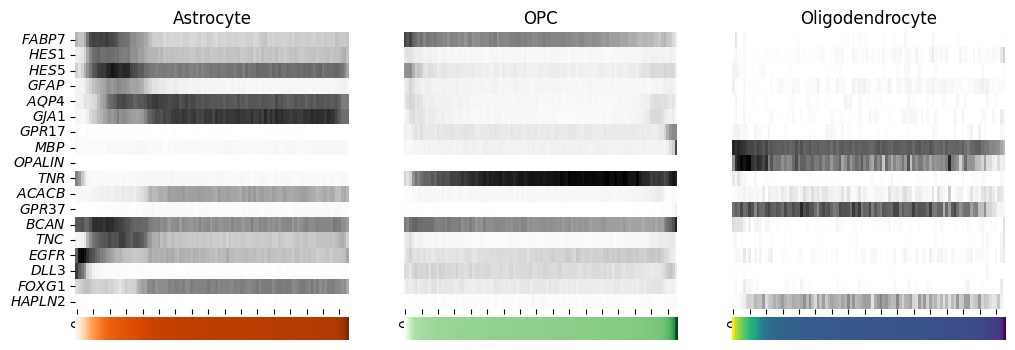

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
top_genes = [
    'FABP7', 'HES1','HES5',  'GFAP', 'AQP4', 'GJA1', 'GPR17','MBP',
    'OPALIN', 'TNR',  'ACACB',  'GPR37',
    'HES1','BCAN', 'TNC',  #glioblasts
   'GJA1','AQP4', #pre-Astro
   'EGFR', "DLL3", #pre-OPC
    "FOXG1",
    "HAPLN2"
]

# Ensure uniqueness and preserve order
top_genes = list(dict.fromkeys(top_genes))


# Parameters
n_bins = 100

# Set up figure and layout
fig = plt.figure(figsize=(4 * len(paths), 4))
gs = gridspec.GridSpec(2, len(paths), height_ratios=[12, 1], hspace=0.05)

for ipath, (descr, path) in enumerate(paths):
    adata = lineage_pseudotime[descr]
    pseudotime = adata.obs['dpt_pseudotime'].copy()

    # 1. Z-score expression across all cells for selected genes
    raw_expr = adata[:, top_genes].to_df()
    df_expr = (raw_expr - raw_expr.min(axis=0)) / (raw_expr.max(axis=0) - raw_expr.min(axis=0))


    # 2. Assign pseudotime bins
    bins = pd.qcut(pseudotime, q=n_bins, labels=False)
    df_expr['pseudotime_bin'] = bins

    # 3. Compute average expression per bin
    binned = df_expr.groupby('pseudotime_bin')[top_genes].mean().T

    # 4. Main heatmap
    ax_heat = fig.add_subplot(gs[0, ipath])
    sns.heatmap(
        binned,
        cmap='Greys',
        cbar=False,
        ax=ax_heat,
        yticklabels=(ipath == 0)
    )
    ax_heat.set_title(f'{descr}')
    ax_heat.set_xlabel('')
    if ipath != 0:
        ax_heat.set_ylabel('')
        ax_heat.set_yticklabels([])
    if ipath == 0:
        italic_labels = [r"$\mathit{{{}}}$".format(gene) for gene in binned.index]
        ax_heat.set_yticklabels(italic_labels, rotation=0)
    else:
        ax_heat.set_ylabel('')
        ax_heat.set_yticklabels([])


    # 5. Pseudotime color bar
    ax_bar = fig.add_subplot(gs[1, ipath])
    try:
        bin_df = pd.DataFrame({'pseudotime': pseudotime, 'bin': bins})
        avg_pseudotime = bin_df.groupby('bin')['pseudotime'].mean()
        norm_pseudo = (avg_pseudotime - avg_pseudotime.min()) / (avg_pseudotime.max() - avg_pseudotime.min())
        norm_pseudo = norm_pseudo.values[np.newaxis, :]  # shape (1, n_bins)

        cmap_name = color_map_dict.get(descr, 'viridis')
        rgba = plt.colormaps[cmap_name](norm_pseudo)

        ax_bar.imshow(rgba, aspect='auto')
        ax_bar.set_axis_off()

    except Exception as e:
        print(f"Could not add pseudotime bar for {descr}: {e}")
        ax_bar.set_axis_off()

plt.tight_layout()
plt.savefig("glial_genes_changing_with_lineages_protein_coding.pdf",bbox_inches='tight')
plt.show()


/tmp/ipykernel_23902/820628428.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


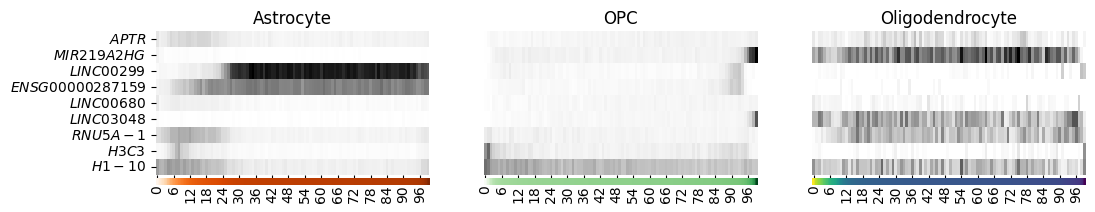

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
top_genes = [
    'APTR','MIR219A2HG',  'LINC00299',  'ENSG00000287159',
    'LINC00680', 'LINC03048',
    'RNU5A-1',
    'H3C3', 'H1-10'
]

# Ensure uniqueness and preserve order
top_genes = list(dict.fromkeys(top_genes))


# Parameters
n_bins = 100

# Set up figure and layout
fig = plt.figure(figsize=(4 * len(paths), 2))
gs = gridspec.GridSpec(2, len(paths), height_ratios=[20, 1], hspace=0.05)

for ipath, (descr, path) in enumerate(paths):
    adata = lineage_pseudotime[descr]
    pseudotime = adata.obs['dpt_pseudotime'].copy()

    # 1. Z-score expression across all cells for selected genes
    raw_expr = adata[:, top_genes].to_df()
    df_expr = (raw_expr - raw_expr.min(axis=0)) / (raw_expr.max(axis=0) - raw_expr.min(axis=0))


    # 2. Assign pseudotime bins
    bins = pd.qcut(pseudotime, q=n_bins, labels=False)
    df_expr['pseudotime_bin'] = bins

    # 3. Compute average expression per bin
    binned = df_expr.groupby('pseudotime_bin')[top_genes].mean().T

    # 4. Main heatmap
    ax_heat = fig.add_subplot(gs[0, ipath])
    sns.heatmap(
        binned,
        cmap='Greys',
        cbar=False,
        ax=ax_heat,
        yticklabels=(ipath == 0)
    )
    ax_heat.set_title(f'{descr}')
    ax_heat.set_xlabel('')
    if ipath != 0:
        ax_heat.set_ylabel('')
        ax_heat.set_yticklabels([])
    if ipath == 0:
        italic_labels = [r"$\mathit{{{}}}$".format(gene) for gene in binned.index]
        ax_heat.set_yticklabels(italic_labels, rotation=0)
    else:
        ax_heat.set_ylabel('')
        ax_heat.set_yticklabels([])


    # 5. Pseudotime color bar
    ax_bar = fig.add_subplot(gs[1, ipath])
    try:
        bin_df = pd.DataFrame({'pseudotime': pseudotime, 'bin': bins})
        avg_pseudotime = bin_df.groupby('bin')['pseudotime'].mean()
        norm_pseudo = (avg_pseudotime - avg_pseudotime.min()) / (avg_pseudotime.max() - avg_pseudotime.min())
        norm_pseudo = norm_pseudo.values[np.newaxis, :]  # shape (1, n_bins)

        cmap_name = color_map_dict.get(descr, 'viridis')
        rgba = plt.colormaps[cmap_name](norm_pseudo)

        ax_bar.imshow(rgba, aspect='auto')
        ax_bar.set_axis_off()

    except Exception as e:
        print(f"Could not add pseudotime bar for {descr}: {e}")
        ax_bar.set_axis_off()

plt.tight_layout()
plt.savefig("glial_genes_changing_with_lineages_lncRNA.pdf",bbox_inches='tight')
plt.show()


/tmp/ipykernel_23902/3828683270.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


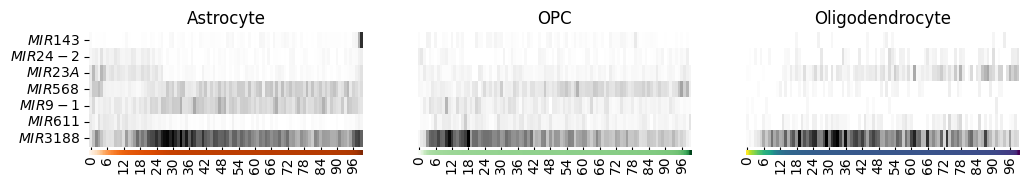

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
top_genes = [
    'MIR143', 'MIR24-2', 'MIR23A', 'MIR568', 'MIR9-1', 'MIR611', 'MIR3188',
    
]

# Ensure uniqueness and preserve order
top_genes = list(dict.fromkeys(top_genes))


# Parameters
n_bins = 100

# Set up figure and layout
fig = plt.figure(figsize=(4 * len(paths), 1.6))
gs = gridspec.GridSpec(2, len(paths), height_ratios=[20, 1], hspace=0.05)

for ipath, (descr, path) in enumerate(paths):
    adata = lineage_pseudotime[descr]
    pseudotime = adata.obs['dpt_pseudotime'].copy()

    # 1. Z-score expression across all cells for selected genes
    raw_expr = adata[:, top_genes].to_df()
    df_expr = (raw_expr - raw_expr.min(axis=0)) / (raw_expr.max(axis=0) - raw_expr.min(axis=0))


    # 2. Assign pseudotime bins
    bins = pd.qcut(pseudotime, q=n_bins, labels=False)
    df_expr['pseudotime_bin'] = bins

    # 3. Compute average expression per bin
    binned = df_expr.groupby('pseudotime_bin')[top_genes].mean().T

    # 4. Main heatmap
    ax_heat = fig.add_subplot(gs[0, ipath])
    sns.heatmap(
        binned,
        cmap='Greys',
        cbar=False,
        ax=ax_heat,
        yticklabels=(ipath == 0)
    )
    ax_heat.set_title(f'{descr}')
    ax_heat.set_xlabel('')
    if ipath != 0:
        ax_heat.set_ylabel('')
        ax_heat.set_yticklabels([])
    if ipath == 0:
        italic_labels = [r"$\mathit{{{}}}$".format(gene) for gene in binned.index]
        ax_heat.set_yticklabels(italic_labels, rotation=0)
    else:
        ax_heat.set_ylabel('')
        ax_heat.set_yticklabels([])


    # 5. Pseudotime color bar
    ax_bar = fig.add_subplot(gs[1, ipath])
    try:
        bin_df = pd.DataFrame({'pseudotime': pseudotime, 'bin': bins})
        avg_pseudotime = bin_df.groupby('bin')['pseudotime'].mean()
        norm_pseudo = (avg_pseudotime - avg_pseudotime.min()) / (avg_pseudotime.max() - avg_pseudotime.min())
        norm_pseudo = norm_pseudo.values[np.newaxis, :]  # shape (1, n_bins)

        cmap_name = color_map_dict.get(descr, 'viridis')
        rgba = plt.colormaps[cmap_name](norm_pseudo)

        ax_bar.imshow(rgba, aspect='auto')
        ax_bar.set_axis_off()

    except Exception as e:
        print(f"Could not add pseudotime bar for {descr}: {e}")
        ax_bar.set_axis_off()

plt.tight_layout()
plt.savefig("glial_genes_changing_with_lineages_miRNA.pdf",bbox_inches='tight')
plt.show()


/tmp/ipykernel_23902/174104089.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


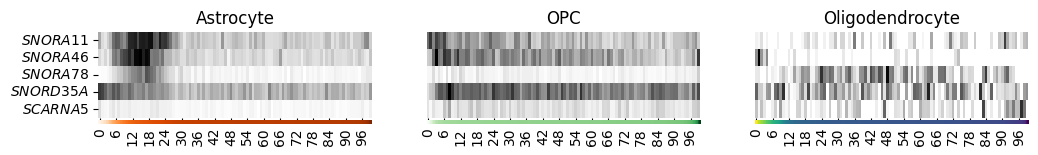

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
top_genes = [
   
    'SNORA11', 'SNORA46', 'SNORA78',  'SNORD35A', 'SCARNA5', 
]

# Ensure uniqueness and preserve order
top_genes = list(dict.fromkeys(top_genes))


# Parameters
n_bins = 100

# Set up figure and layout
fig = plt.figure(figsize=(4 * len(paths), 1.2))
gs = gridspec.GridSpec(2, len(paths), height_ratios=[20, 1], hspace=0.05)

for ipath, (descr, path) in enumerate(paths):
    adata = lineage_pseudotime[descr]
    pseudotime = adata.obs['dpt_pseudotime'].copy()

    # 1. Z-score expression across all cells for selected genes
    raw_expr = adata[:, top_genes].to_df()
    df_expr = (raw_expr - raw_expr.min(axis=0)) / (raw_expr.max(axis=0) - raw_expr.min(axis=0))


    # 2. Assign pseudotime bins
    bins = pd.qcut(pseudotime, q=n_bins, labels=False)
    df_expr['pseudotime_bin'] = bins

    # 3. Compute average expression per bin
    binned = df_expr.groupby('pseudotime_bin')[top_genes].mean().T

    # 4. Main heatmap
    ax_heat = fig.add_subplot(gs[0, ipath])
    sns.heatmap(
        binned,
        cmap='Greys',
        cbar=False,
        ax=ax_heat,
        yticklabels=(ipath == 0)
    )
    ax_heat.set_title(f'{descr}')
    ax_heat.set_xlabel('')
    if ipath != 0:
        ax_heat.set_ylabel('')
        ax_heat.set_yticklabels([])
    if ipath == 0:
        italic_labels = [r"$\mathit{{{}}}$".format(gene) for gene in binned.index]
        ax_heat.set_yticklabels(italic_labels, rotation=0)
    else:
        ax_heat.set_ylabel('')
        ax_heat.set_yticklabels([])


    # 5. Pseudotime color bar
    ax_bar = fig.add_subplot(gs[1, ipath])
    try:
        bin_df = pd.DataFrame({'pseudotime': pseudotime, 'bin': bins})
        avg_pseudotime = bin_df.groupby('bin')['pseudotime'].mean()
        norm_pseudo = (avg_pseudotime - avg_pseudotime.min()) / (avg_pseudotime.max() - avg_pseudotime.min())
        norm_pseudo = norm_pseudo.values[np.newaxis, :]  # shape (1, n_bins)

        cmap_name = color_map_dict.get(descr, 'viridis')
        rgba = plt.colormaps[cmap_name](norm_pseudo)

        ax_bar.imshow(rgba, aspect='auto')
        ax_bar.set_axis_off()

    except Exception as e:
        print(f"Could not add pseudotime bar for {descr}: {e}")
        ax_bar.set_axis_off()

plt.tight_layout()
plt.savefig("glial_genes_changing_with_lineages_smallRNA.pdf",bbox_inches='tight')
plt.show()


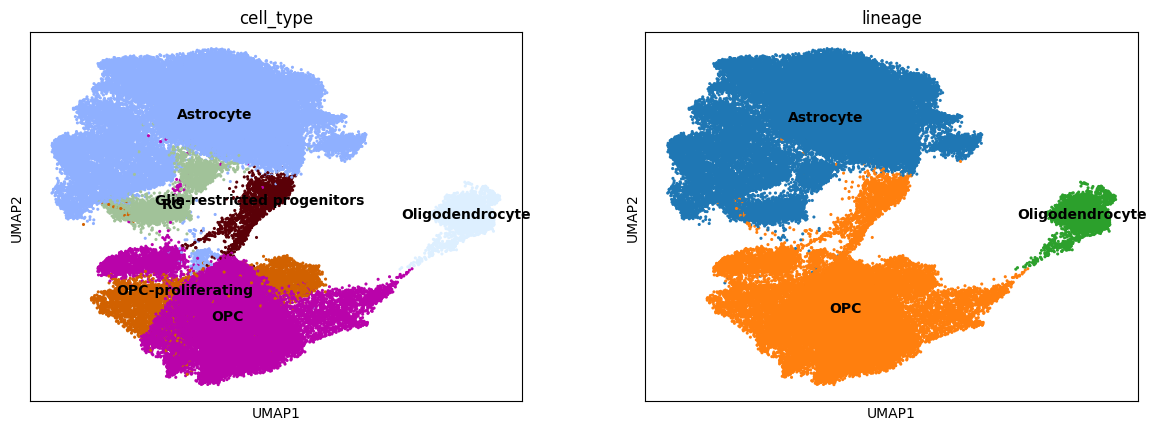

In [78]:
sc.pl.umap(glial_adata, color=["cell_type", "lineage"], legend_loc="on data",size=20)

/tmp/ipykernel_23902/4121485419.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  region_props = region_counts.pivot_table(index='lineage', columns='region', values='count', fill_value=0)


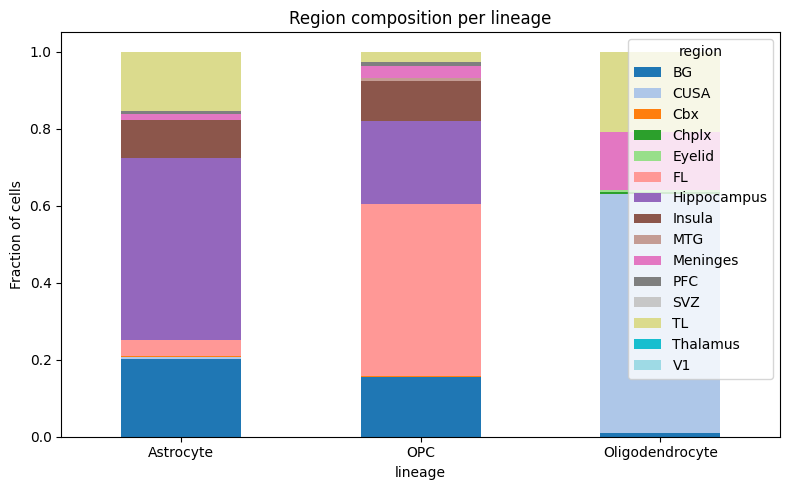

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have `lineage` and `region` annotated in obs
df = glial_adata.obs[['lineage', 'region']].copy()

# Count cells per (lineage, region) pair
region_counts = df.value_counts().reset_index(name='count')

# Normalize to get fraction per lineage
region_props = region_counts.pivot_table(index='lineage', columns='region', values='count', fill_value=0)
region_props = region_props.div(region_props.sum(axis=1), axis=0)

# Plot
region_props.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8, 5))
plt.ylabel("Fraction of cells")
plt.title("Region composition per lineage")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [58]:
glial_adata.write("TSB_Glial.h5ad")